# Problem 1

In [1]:
import StringIO
import base64
import struct  

from IPython.core.display import HTML
from IPython.core.display import display

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

In [2]:
from scipy.io import wavfile
from scipy import linalg
from scipy.signal import resample
import matplotlib.pyplot as plt
import numpy as np
import sys

%matplotlib inline

def load_wav(filename, samplerate = 44100):
    rate, data = wavfile.read(filename)

    if len(data.shape) > 1:
        data = (data[:, 0] + data[:, 1]) / 2
  
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return data.astype(np.int16)

def toeplitz(N, alpha):
    func = lambda x: np.sqrt(4.0 * alpha / np.pi) * np.exp(-alpha * x * x)
    first_line = np.fromfunction(func, [N])
    return linalg.toeplitz(first_line)

def graphics(alphas, data):
    
    n = len(alphas)
    experiment_names = alphas

    fig, axes = plt.subplots(1, n, sharey=True, figsize=(16,4))
    if n == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        key = alphas[i]
        new_data = toeplitz(len(data), key).dot(data)
        ax.plot(data[:400])
        ax.plot(new_data[:400])
        ax.set_xlabel('samples')
        ax.set_title('Alpha = {0}'.format(key))

    axes[0].set_ylabel('Time, s')
    plt.suptitle('Convolution results', fontsize=16,  y=1.03)


For $N \times N$ matrix we need $\frac{8N^2}{10^6}$ megabytes in operation memory. If size of operation memory is 4 Gb, $N \leq 22360$. For convenience I used 5000.

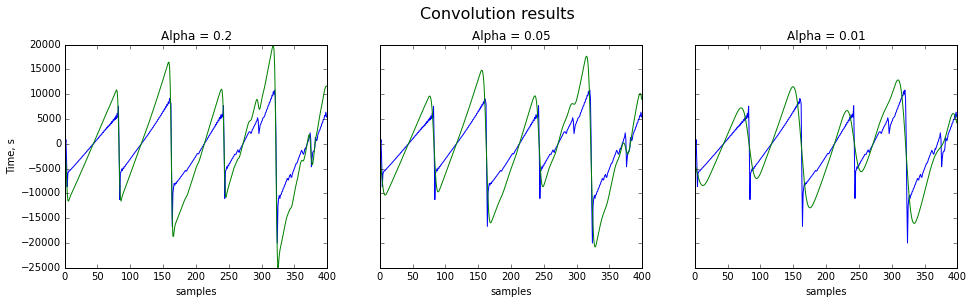

In [3]:
sample_rate = 8000
crop = 5000

data = load_wav('sample.wav', sample_rate)
data = data[:crop]

graphics([1/5.0, 1.0/20, 1/100.0], data)
wavPlayer(toeplitz(crop, 1.0/20).dot(data).astype(np.int16), sample_rate)

The slowest run took 15.37 times longer than the fastest. This could mean that an intermediate result is being cached 
1000000 loops, best of 3: 1.75 µs per loop
The slowest run took 6.97 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.46 µs per loop
The slowest run took 8.76 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 6.86 µs per loop
The slowest run took 4.48 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 22.1 µs per loop
10000 loops, best of 3: 72.2 µs per loop
1000 loops, best of 3: 387 µs per loop
1000 loops, best of 3: 1 ms per loop
100 loops, best of 3: 2.02 ms per loop
100 loops, best of 3: 3.76 ms per loop
100 loops, best of 3: 8.17 ms per loop
10 loops, best of 3: 21.1 ms per loop


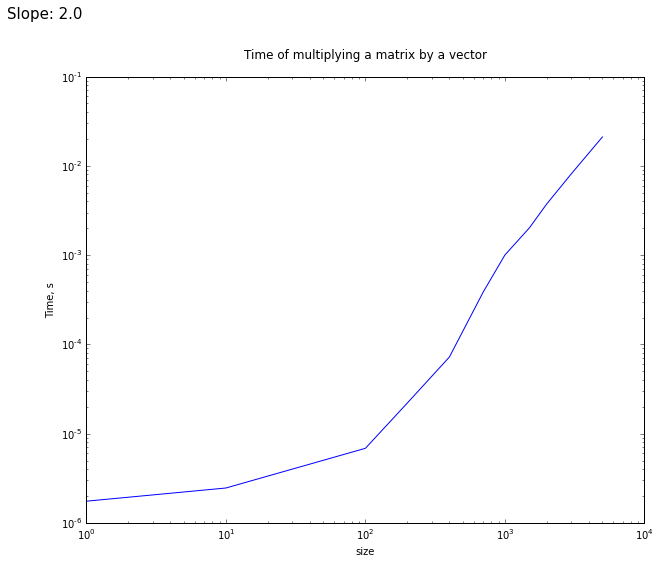

In [4]:
N = [1, 10, 100, 200, 400, 700, 1000, 1500, 2000, 3000, 5000]
times = []
for i in N:
    T = toeplitz(i, 1.0/20)
    res = %timeit -o T.dot(data[:i])
    times.append(res.best)
    
plt.figure(figsize = (10, 8))

plt.loglog(N, times, label='Benchmark')
slope, intercept=np.polyfit(np.log(N[5:]), np.log(times[5:]), 1)
plt.text(0.5, 0.5, 'Slope: {0:.1f}'.format(slope), fontsize = 15, ha='center', va='center') 

plt.title('Time of multiplying a matrix by a vector', y = 1.03)
plt.xlabel('size')
plt.ylabel('Time, s')

# Problem 2

In [5]:
import numpy as np
from  scipy import linalg

def gram_schmidt(matrix, modified = False):
    ret_matrix = np.copy(matrix)
    index = 0
    for u in ret_matrix:
        if modified:
            uu = u
        else:
            uu = np.copy(u)
        for v in ret_matrix[:index]:
            u -= v * np.dot(uu, v)
        u /= np.sqrt(np.dot(u, u))
        index += 1
    return ret_matrix
    
def gram_matrix(matrix):
    return matrix.dot(matrix.T)

def ortho_error(matrix):
    return np.linalg.norm(gram_matrix(matrix) - np.identity(matrix.shape[0]))

size = 1000
random_matrix = np.random.rand(size, size)
print 'Error for random matrix', ortho_error(gram_schmidt(random_matrix))

Error for random matrix 1.43967998833e-10


In [6]:
hilbert_matrix = linalg.hilbert(size)

In [7]:
print 'Error for hilbert matrix', ortho_error(gram_schmidt(hilbert_matrix))

Error for hilbert matrix 992.774193012


It means that Gram–Schmidt algorithm is numerically unstable due to rounding errors.

In [8]:
print 'Error for hilbert matrix using modified algorithm', ortho_error(gram_schmidt(hilbert_matrix, True))

Error for hilbert matrix using modified algorithm 6.74665423198


# Problem 3

* $
\|Ux\|_2 = (Ux, Ux) = (U^*Ux, x) = (x, x) = \|x\|_2
$

* $\begin{align}
\Vert UAV \Vert_2 = \sup_{x \ne 0} \frac{\Vert UAV x \Vert_2}{\Vert x \Vert_2}  = \sup_{x \ne 0} \frac{\Vert AV x \Vert_2}{\Vert V x \Vert_2} = \sup_{Vx \ne 0} \frac{\Vert AV x \Vert_2}{\Vert V x \Vert_2} = \sup_{y \ne 0} \frac{\Vert A y \Vert_2}{\Vert y \Vert_2} = \Vert A \Vert_2
\end{align}$

* $ (AA^*)_{ij} = \sum_{k=1}^na_{ik}a^*_{jk} \\
\text{trace}(A^*A) = \text{trace}(AA^*) = \sum_{i=1}^n\sum_{k=1}^na_{ik}a^*_{ik} = \sum_{i=1}^n\sum_{j=1}^n|a_{ij}|^2 = \|A\|^2_F $

* $ \|UAV\|^2_F = \text{trace}(V^*A^*U^*UAV) = \text{trace}(V^*A^*AV)= \text{trace}(V^*A^*AV) = \text{trace}(A^*AVV^*) = \text{trace}(A^*A) = \|A\|^2_F $

# Problem 4

 $$
\Vert A \Vert_* = \sup_{x \ne 0} \frac{\Vert A x \Vert_*}{\Vert x \Vert_*} = \sup_{x \ne 0} \big \Vert A  \frac{x}{\Vert x \Vert_*}\big\Vert_* = \sup_{\Vert x \Vert_* = 1} \Vert A x \Vert_*
$$

* $$ \sum_{i = 1}^m |x_i| = 1 \\
\Vert A x \Vert_1 = \sum_{i=1}^n\big|\sum_{j = 1}^m a_{ij}x_j\big| \leqslant \sum_{i = 1}^n \sum_{j = 1}^m |a_{ij}||x_j| = \sum_{j = 1}^m |x_j| \sum_{i = 1}^n |a_{ij}| \leqslant \max_{j}\sum_{i = 1}^n |a_{ij}| \\
$$
The equality is achieved when $x_j = 1$ if $j = \text{arg} \max_{j}\sum_{i = 1}^n |a_{ij}|$ and $x_j = 0$ otherwise.

* $$ \max_{i} |x_i| = 1 \\
\Vert A x \Vert_{\infty} = \max_{i}\big|\sum_{j = 1}^m a_{ij}x_j\big| \leqslant \max_{i} \sum_{j = 1}^m |a_{ij}||x_j| \leqslant \max_{i} \sum_{j = 1}^m |a_{ij}|
$$
The equality is achieved when $i = \max_{i} \sum_{j = 1}^m |a_{ij}|$ and $x_j = \text{sign}(a_{ij})$.

* If $\Vert x \Vert$ is norm and A is nonsingular operator, $\Vert A x \Vert$ is also norm.
Example: $\Vert x \Vert = \big[(x_1 + x_n)^2 + x_2^2 + ... + x_n^2\big]^{1/2}$